Using device: cpu
Found 624 images in the test folder.

--- Evaluating ResNet-18 ---

==================== REPORT FOR ResNet-18 ====================
              precision    recall  f1-score   support

      NORMAL       0.99      0.46      0.63       234
   PNEUMONIA       0.76      1.00      0.86       390

    accuracy                           0.80       624
   macro avg       0.87      0.73      0.74       624
weighted avg       0.84      0.80      0.77       624



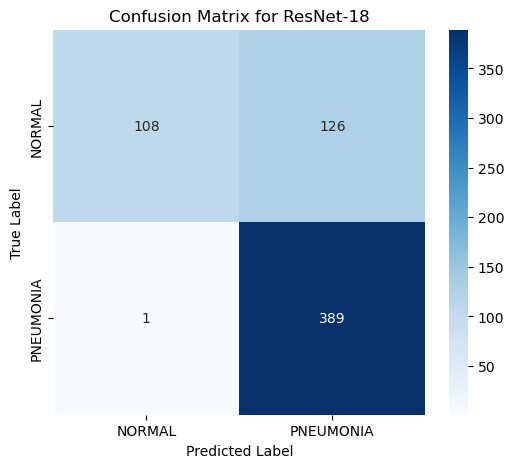


--- Evaluating EfficientNet-B0 ---

==================== REPORT FOR EfficientNet-B0 ====================
              precision    recall  f1-score   support

      NORMAL       0.94      0.65      0.77       234
   PNEUMONIA       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624



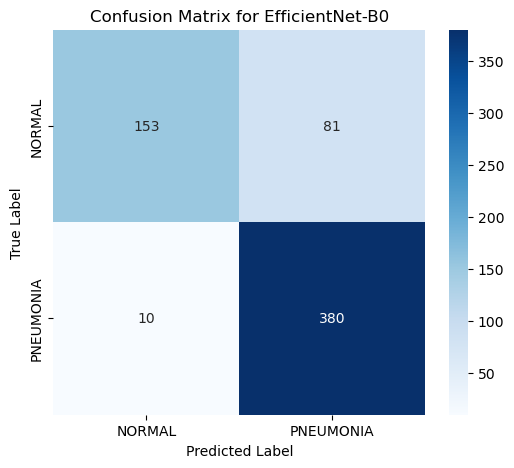


--- Evaluating Vision Transformer ---

==================== REPORT FOR Vision Transformer ====================
              precision    recall  f1-score   support

      NORMAL       0.78      0.26      0.40       234
   PNEUMONIA       0.68      0.96      0.80       390

    accuracy                           0.70       624
   macro avg       0.73      0.61      0.60       624
weighted avg       0.72      0.70      0.65       624



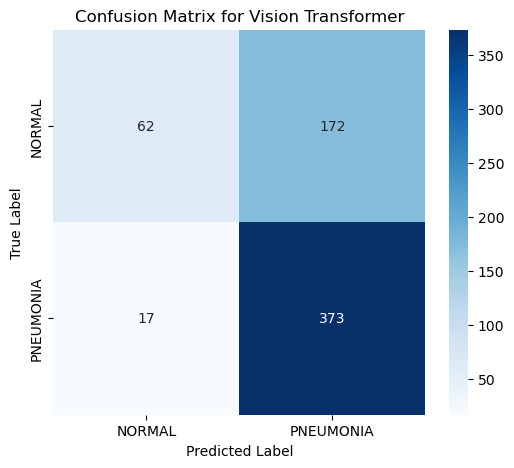


========================= FINAL COMPARISON =========================
   Model Architecture Test Accuracy Test Recall (NORMAL) Test Recall (PNEUMONIA) F1-Score (Weighted Avg)
0           ResNet-18        79.65%                 0.46                    1.00                    0.77
1     EfficientNet-B0        85.42%                 0.65                    0.97                    0.85
2  Vision Transformer        69.71%                 0.26                    0.96                    0.65


In [4]:
# =============================================================================
#                 FINAL TESTING AND COMPARATIVE ANALYSIS
# =============================================================================

# IMPORTS AND SETUP
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# CONFIGURATION 
DATA_DIR = '../chest_xray'
BATCH_SIZE = 32
MODEL_PATHS = {
    "ResNet-18": "../best_pneumonia_classifier_weight_loss.pth",
    "EfficientNet-B0": "../best_model_pneumonia.pth",
    "Vision Transformer": "../best_model_pneumonia_vit.pth"
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# LOAD TEST DATA
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dir = DATA_DIR + '/test'
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = test_dataset.classes
print(f"Found {len(test_dataset)} images in the test folder.")

# EVALUATION FUNCTION
def evaluate_model(model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    print("\n" + "="*20 + f" REPORT FOR {model_name} " + "="*20)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return report

# RUN EVALUATION FOR ALL MODELS
results = {}
for model_name, path in MODEL_PATHS.items():
    print(f"\n--- Evaluating {model_name} ---")
    
    # Create the correct model architecture
    if "ResNet" in model_name:
        from torchvision.models import ResNet18_Weights
        model_arch = models.resnet18(weights=None)
        num_ftrs = model_arch.fc.in_features
        model_arch.fc = nn.Linear(num_ftrs, len(class_names))
    elif "EfficientNet" in model_name:
        from torchvision.models import EfficientNet_B0_Weights
        model_arch = models.efficientnet_b0(weights=None)
        num_ftrs = model_arch.classifier[1].in_features
        model_arch.classifier[1] = nn.Linear(num_ftrs, len(class_names))
    elif "Vision Transformer" in model_name:
        from torchvision.models import ViT_B_16_Weights
        model_arch = models.vit_b_16(weights=None)
        num_ftrs = model_arch.heads.head.in_features
        model_arch.heads.head = nn.Linear(num_ftrs, len(class_names))
        
    try:
        results[model_name] = evaluate_model(model_arch, path)
    except FileNotFoundError:
        print(f"Model file not found for {model_name} at path: {path}. Skipping.")
        
# FINAL COMPARATIVE ANALYSIS
print("\n" + "="*25 + " FINAL COMPARISON " + "="*25)
comparison_data = []
for model_name, report in results.items():
    comparison_data.append({
        "Model Architecture": model_name,
        "Test Accuracy": f"{report['accuracy']*100:.2f}%",
        "Test Recall (NORMAL)": f"{report['NORMAL']['recall']:.2f}",
        "Test Recall (PNEUMONIA)": f"{report['PNEUMONIA']['recall']:.2f}",
        "F1-Score (Weighted Avg)": f"{report['weighted avg']['f1-score']:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string())
